# Анализ результатов АБ-теста

## Введение

В данном задании вам нужно будет

* проанализировать АБ тест, проведенный на реальных пользователях Яндекса
* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
* определить характер этих изменений и практическую значимость вводимого изменения
* понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

Описание данных:

* userID: уникальный идентификатор пользователя
* browser: браузер, который использовал userID
* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* n_clicks: количество кликов, которые пользоваль совершил за n_queries
* n_queries: количество запросов, который совершил userID, пользуясь браузером browser
* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv('ab_browser_test.csv')

df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


### Q1 

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.

In [3]:
df.groupby(['slot'])['n_clicks'].agg(np.sum)

slot
control    3210027
exp        3261823
Name: n_clicks, dtype: int64

In [4]:
print('Answer is {}%'.format(round(100*((3261823/3210027) - 1), 3)))

Answer is 1.614%


### Q2

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [5]:
exp_clicks = df[(df['slot'] == 'exp')]['n_clicks'].values
control_clicks = df[(df['slot'] == 'control')]['n_clicks'].values

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [7]:
def stat_intervals(stat, alpha = .05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
%%time

np.random.seed(0)

exp_mean_scores = list(map(np.mean, get_bootstrap_samples(exp_clicks, 1000)))
control_mean_scores = list(map(np.mean, get_bootstrap_samples(control_clicks, 1000)))

exp_median_scores = list(map(np.median, get_bootstrap_samples(exp_clicks, 1000)))
control_median_scores = list(map(np.median, get_bootstrap_samples(control_clicks, 1000)))

Wall time: 28.6 s


In [9]:
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(exp_mean_scores, control_mean_scores)))
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(exp_median_scores, control_median_scores)))

In [10]:
print("95% confidence interval for the difference between means",  stat_intervals(delta_mean_scores))

95% confidence interval for the difference between means [-0.40475697 -0.19172563]


In [11]:
print("95% confidence interval for the difference between means",  stat_intervals(delta_median_scores))

95% confidence interval for the difference between means [-1. -1.]


#### Ответ:

* 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо
* 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо

### Q3

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

**Все ответы неверны**

### Q4

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид $\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

* $\overline{X}$ — среднее значение в выборке — было распределено нормально 
* $N(\mu,\frac{σ^2}{n})$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c $n−1$ степенями свободы $\chi^2(n−1)$

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

1. Получите из данных n_boot_samples псевдовыборок.
2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared).
3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью `scipy.stats.probplot` для нормального распределения.
4. Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью `scipy.stats.probplot`.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:
* np.random.seed(0)
* n_boot_samples = 500

В качестве ответа отметьте верные утвердения о значениях $R^2$, которые генерирует `scipy.stats.probplot` при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.

In [39]:
n_boot_samples = 500

In [40]:
np.random.seed(0)

vyborki = get_bootstrap_samples(control_clicks, n_boot_samples)

In [41]:
def tss(data):
    return np.sum((data - np.mean(data))**2) 

In [42]:
mean_scores = list(map(np.mean, vyborki))
tss_scores = list(map(tss, vyborki))

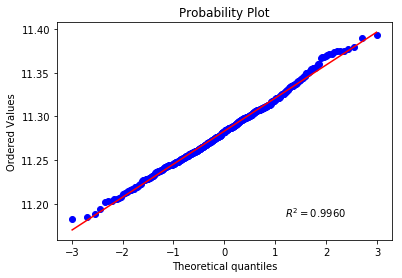

In [48]:
stats.probplot(mean_scores, dist = 'norm', plot = plt, rvalue = True)
plt.show()

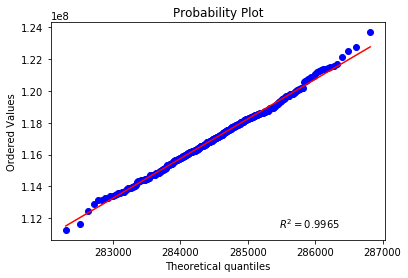

In [49]:
stats.probplot(tss_scores, dist="chi2", sparams = (control_clicks.shape[0]-1), plot=plt, rvalue = True)
plt.show()

**Ответ:**

* $R^2$ для выборочного среднего получился больше, чем 0.99
* $R^2$ R для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99

### Q5

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [62]:
exp_clicks = df[(df['slot'] == 'exp')].groupby(['userID'])['n_clicks'].agg(np.sum).values
cont_clicks = df[(df['slot'] == 'control')].groupby(['userID'])['n_clicks'].agg(np.sum).values

In [63]:
stats.mannwhitneyu(exp_clicks, cont_clicks)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

**Ответ**:

* Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками

### Q6

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с $\alpha=0.05$.

Какое заключение можно сделать исходя из полученных результатов?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [91]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [92]:
browser = df.groupby(['slot', 'browser','userID'], as_index = False)['n_clicks'].agg(np.sum)

browser_exp = browser[(browser['slot'] == 'exp')]
browser_cont = browser[(browser['slot'] == 'control')]

browsers = np.unique(browser.browser)

In [93]:
mann_ps = []

for i in range(len(browsers)):
    mann_ps.append(stats.mannwhitneyu(browser_exp[(browser_exp['browser'] == browsers[i])]['n_clicks'], 
                       browser_cont[(browser_cont['browser'] == browsers[i])]['n_clicks'])[1]) 

In [94]:
reject, p_corrected, a1, a2 = multipletests(mann_ps, 
                                            alpha = 0.05, 
                                            method = 'holm') 

In [95]:
stat_df = pd.DataFrame({'browser': browsers, 'mann_ps': mann_ps, 'reject': reject, 'p_corrected': p_corrected})

stat_df

,browser,mann_ps,p_corrected,reject
0,Browser #14,0.000000,0.000000,True
1,Browser #17,0.037401,0.149602,False
2,Browser #2,0.027244,0.136219,False
3,Browser #20,0.453667,0.815212,False
4,Browser #22,0.257406,0.772217,False
5,Browser #4,0.407606,0.815212,False


**Ответ:**
    
* 5

### Q7

Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

In [98]:
non_click = df.groupby(['slot', 'browser'], as_index = False)['n_nonclk_queries', 'n_queries'].agg(np.sum)

non_click['share'] = round(non_click['n_nonclk_queries']*100/non_click['n_queries'], 1)

non_click

,slot,browser,n_nonclk_queries,n_queries,share
0,control,Browser #14,161252,279998,57.6
1,control,Browser #17,75837,208921,36.3
2,control,Browser #2,260259,566239,46.0
3,control,Browser #20,78548,193752,40.5
4,control,Browser #22,315470,777135,40.6
5,control,Browser #4,498254,1060771,47.0
6,exp,Browser #14,123656,282606,43.8
7,exp,Browser #17,77614,210123,36.9
8,exp,Browser #2,246514,548019,45.0
9,exp,Browser #20,72998,187283,39.0


**Ответ**:

* С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.